In [1]:
import numpy as np
import pandas as pd
import functions as fn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def MAD_mean_ratio(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.mean(y_true))) * 100

sns.set(style='darkgrid')
#pd.set_option('display.max_rows', 16)

#original data from sharadar quandl fundamental data had a different format
#the fundamental data from WRDS comes already staked
#staked means the data for each ticker=stock is staked in a pile one on top of the next
#the model here is completely cross sectional, does not consider the timeseries structure of the data

In [3]:
dfroe = pd.read_csv("mixed_cap_roe_UNSTACKED_new.csv")
dfdates = dfroe.datetime
dfroe.drop(['datetime'], axis=1, inplace=True)
dfroe.replace([np.inf, -np.inf, np.NINF, -np.NINF], np.nan, inplace=True)
dfpio = pd.read_csv("mixed_cap_piotroski_UNSTACKED_new.csv")
dfpio.drop(['datetime'], axis=1, inplace=True)
dfpio.replace([np.inf, -np.inf, np.NINF, -np.NINF], np.nan, inplace=True)

dfpermnos = pd.read_csv("mixed_cap_permnos_with_wrds_data_new.csv")
syms1=dfpermnos.permno.tolist()
symsP=dfpermnos.permno.tolist()

dfidates = pd.DatetimeIndex(dfdates)
dates1=dfidates #

In [4]:
#need to build a df with mid prices unstacked, each column is mid prices for one stock
#this is the daily close mid_price, upon which all return calcs will be based
dfmp = pd.read_csv("mixed_cap_mid_price_UNSTACKED_new.csv")
dfmp.drop(['datetime'], axis=1, inplace=True)
dfmp.replace([np.inf, -np.inf, np.NINF, -np.NINF], np.nan, inplace=True)
mid=dfmp

#need to build a df with 1Day returns, each column is for one stock
Ret1 = fn.calculateReturns(mid.copy(), 1) #df, 


# hold for 21 days (1 month)
holdingDays = 21

# monthly return
RetM = fn.calculateReturns(mid.copy(), holdingDays) #df, monthly returns calculated daily
#del matP

# shifted next month's return to today's row to use as response variable.
# Can enter only at next day's close.
RetFut = RetM.copy().shift(-(holdingDays+1)) #df, monthly returns calculated daily shifted to today

In [5]:
RetFut.shape
# (days, permnos)

(1020, 990)

In [6]:
#del RetM, mid
#############################
m = RetFut.shape[0]
trainSize = m // 2               #
testSize = m - trainSize         #
#############################

RetFutTrain = RetFut.iloc[:trainSize] #df, 
RetFutTest = RetFut.iloc[trainSize:] #df, 
Ret1train = Ret1.iloc[:trainSize] #df, 
Ret1test = Ret1.iloc[trainSize:] #df, 

#flattening and repetition of the date vector, this is the height of daily calculated return column after stacking of stocks
flat_train = RetFutTrain.size #
flat_test = RetFutTest.size #
m0 = RetFut.shape[0] #original number of observations, 
nStocks = len(syms1) #original number of stocks,

datesTrain = dates1.to_numpy()[:trainSize].flatten() #daily dates, 
datesTest = dates1.to_numpy()[trainSize:].flatten() #daily dates,

In [7]:
RetFutTrain.shape
# (train days, permnos)

(510, 990)

In [8]:
flat_train #all train days with permnos = 510*990

504900

In [9]:
#del dates1, datesP, RetFut

# Combine different independent variables into one matrix X for training
Xtrain = np.nan * np.empty((trainSize * len(symsP), 2)) #
Xtest = np.nan * np.empty((testSize * len(symsP), 2)) #

# dependent variable, stacked and divided into train and test
RetFutTrain = pd.DataFrame(np.where(RetFutTrain>0,1,0)) #categorical tag for logistic
RetFutTest = pd.DataFrame(np.where(RetFutTest>0,1,0)) #categorical tag for logistic
Ytrain = RetFutTrain.to_numpy().flatten()[:,np.newaxis] #arr, 
Ytest = RetFutTest.to_numpy().flatten()[:,np.newaxis] #arr, 

ROE = dfroe
ROE.fillna(value=-99.5, inplace=True) #substitutes NA (not available) and NAN (not a number)
ROE[ROE <= 0] = np.nan #gets rid of all negative values of ROE when dropna is applied eventually

 
PIO = dfpio
PIO.fillna(value=-99.5, inplace=True) #substitutes NA (not available) and NAN (not a number)
PIO[PIO <= 0] = np.nan #gets rid of all negative values of PIO when dropna is applied eventually


In [10]:
#At this point PIO and ROE are dfs with shape row*cols
#But now we are going to take the columns and stack them to verical shape
Xtrain[:,0] = np.log1p(PIO.iloc[:trainSize].to_numpy()).flatten() #numpy.ndarray, 
Xtrain[:,1] = np.log1p(ROE.iloc[:trainSize].to_numpy()).flatten() #numpy.ndarray, 

Xtest[:,0] = np.log1p(PIO.iloc[trainSize:].to_numpy()).flatten() #numpy.ndarray, 
Xtest[:,1] = np.log1p(ROE.iloc[trainSize:].to_numpy()).flatten() #numpy.ndarray, 


In [11]:
Xtrain.shape

(504900, 2)

In [12]:

#Dropna allows the number of rows in XYtrain to be reduced, the third column being the added Y
#the dropna is eliminating any rows where PIO and ROE columns have NaN, keeping only those rows
#where there is PIO, ROE and return data (monthly data). We need to keep the dropna
XYtrain = pd.DataFrame(np.hstack([Xtrain, Ytrain])).dropna(how='any', axis=0) #df, 
XYtest = pd.DataFrame(np.hstack([Xtest, Ytest])).dropna(how='any', axis=0) #df, 

ixCleanTrain = XYtrain.index.to_numpy()
ixCleanTest = XYtest.index.to_numpy()

XYtrain = XYtrain.to_numpy()
XYtest = XYtest.to_numpy()

Xtrain, ytrain = XYtrain[:, 0:-1], XYtrain[:, -1][:,np.newaxis]
Xtest, ytest = XYtest[:, 0:-1], XYtest[:, -1][:,np.newaxis]

In [13]:
XYtrain

array([[1.60943791, 0.11600368, 1.        ],
       [2.19722458, 0.11064652, 1.        ],
       [1.79175947, 0.04305949, 1.        ],
       ...,
       [2.07944154, 0.16126815, 1.        ],
       [1.60943791, 0.11064652, 1.        ],
       [1.94591015, 0.34924743, 1.        ]])

In [14]:
XYtrain.shape

(16507, 3)

In [15]:
Xtrain

array([[1.60943791, 0.11600368],
       [2.19722458, 0.11064652],
       [1.79175947, 0.04305949],
       ...,
       [2.07944154, 0.16126815],
       [1.60943791, 0.11064652],
       [1.94591015, 0.34924743]])

In [16]:
Xtrain.shape

(16507, 2)

In [17]:
ytrain

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
np.random.seed(2)

# Create the pipe to tune

pipe = Pipeline([("scaler",StandardScaler()),("rf",RandomForestClassifier())])

#prepare parameter_grid

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 10)]

# Number of features to consider at every split
max_features = [round(x,2) for x in np.linspace(start = 0.1, stop = .5, num = 5)]

# Max depth of the tree
max_depth = [round(x,2) for x in np.linspace(start = 2, stop = 5, num = 3)]

# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start = 15, stop = 100, num = 10)]

# Method of selecting training subset for training each tree
bootstrap = [False,True]


# Save these parameters in a dictionary
param_grid = {'rf__n_estimators': n_estimators,
               'rf__max_features': max_features,
               'rf__max_depth': max_depth,
               'rf__min_samples_leaf': min_samples_leaf,
               'rf__bootstrap': bootstrap,
              }
 
# Print the dictionary
print(param_grid)

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

#Random Search
# Uncomment below line to see detail about RandomizedSearchCV function
# help(RandomizedSearchCV)

# Random search of parameters by searching across 50 different combinations

kfold = KFold(n_splits = 5, shuffle = True)
rs = 41

{'rf__n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 20], 'rf__max_features': [0.1, 0.2, 0.3, 0.4, 0.5], 'rf__max_depth': [2.0, 3.5, 5.0], 'rf__min_samples_leaf': [15, 24, 33, 43, 52, 62, 71, 81, 90, 100], 'rf__bootstrap': [False, True]}


In [19]:
rso = RandomizedSearchCV(pipe, 
                               param_distributions = param_grid, 
                               n_iter = 100,                               
                               random_state= rs,
                               cv = kfold
                               )
# Fit the model to find the best hyperparameter values
rso.fit(Xtrain, ytrain.ravel())

print(rso.best_params_)

# Assign the best model to best_random_forest
best_random_forest = rso.best_estimator_

# Initialize random_state to 42
best_random_forest.random_state = rs


scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

# Fit the best random forest model on train dataset

treeModel = best_random_forest.fit(Xtrain, ytrain)

#from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

print( ('Number of observations: {:d}').format(trainSize))

print(('score-training-w/score = {}').format(treeModel.score(Xtrain, ytrain)))

# Make "predictions" based on model on training set, reshape back to original matrix dimensions
Ypred = treeModel.predict(Xtrain)
#Ypred = treeModel.predict(Xtrain).reshape(-1,1)

print(('accuracy_score-training = {:.4f}').format(accuracy_score(ytrain, Ypred)))


retPred = np.nan * np.empty((flat_train, 1))
Ypred = np.reshape(Ypred,(Ypred.shape[0],1))#######################################
retPred[ixCleanTrain] = Ypred
retPred = retPred.reshape(RetFutTrain.shape)

{'rf__n_estimators': 9, 'rf__min_samples_leaf': 90, 'rf__max_features': 0.2, 'rf__max_depth': 3.5, 'rf__bootstrap': False}
Number of observations: 510
score-training-w/score = 0.5669715878112316
accuracy_score-training = 0.5670


C:\Users\melan\Anaconda3\lib\site-packages\sklearn\pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


In [20]:
# best model with optimal hyperparameters
treeModel['rf']

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=3.5, max_features=0.2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=90, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=9,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:
treeModel['rf'].feature_importances_
# log1p is natural logarithmic value of x+1 where x belongs to all the input array elements
# the first feature is log(PIO+1), the second one is log(ROE+1), where +1 in log can be ignored

array([0.90947934, 0.09052066])

In [22]:
# extract a single decision tree to plot
estimator = treeModel['rf'].estimators_[4]

In [23]:
estimator

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3.5,
                       max_features=0.2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=90, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1048456564, splitter='best')

In [24]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = ['logPIO', 'logROE'],
                class_names = 'return',
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [25]:
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

0

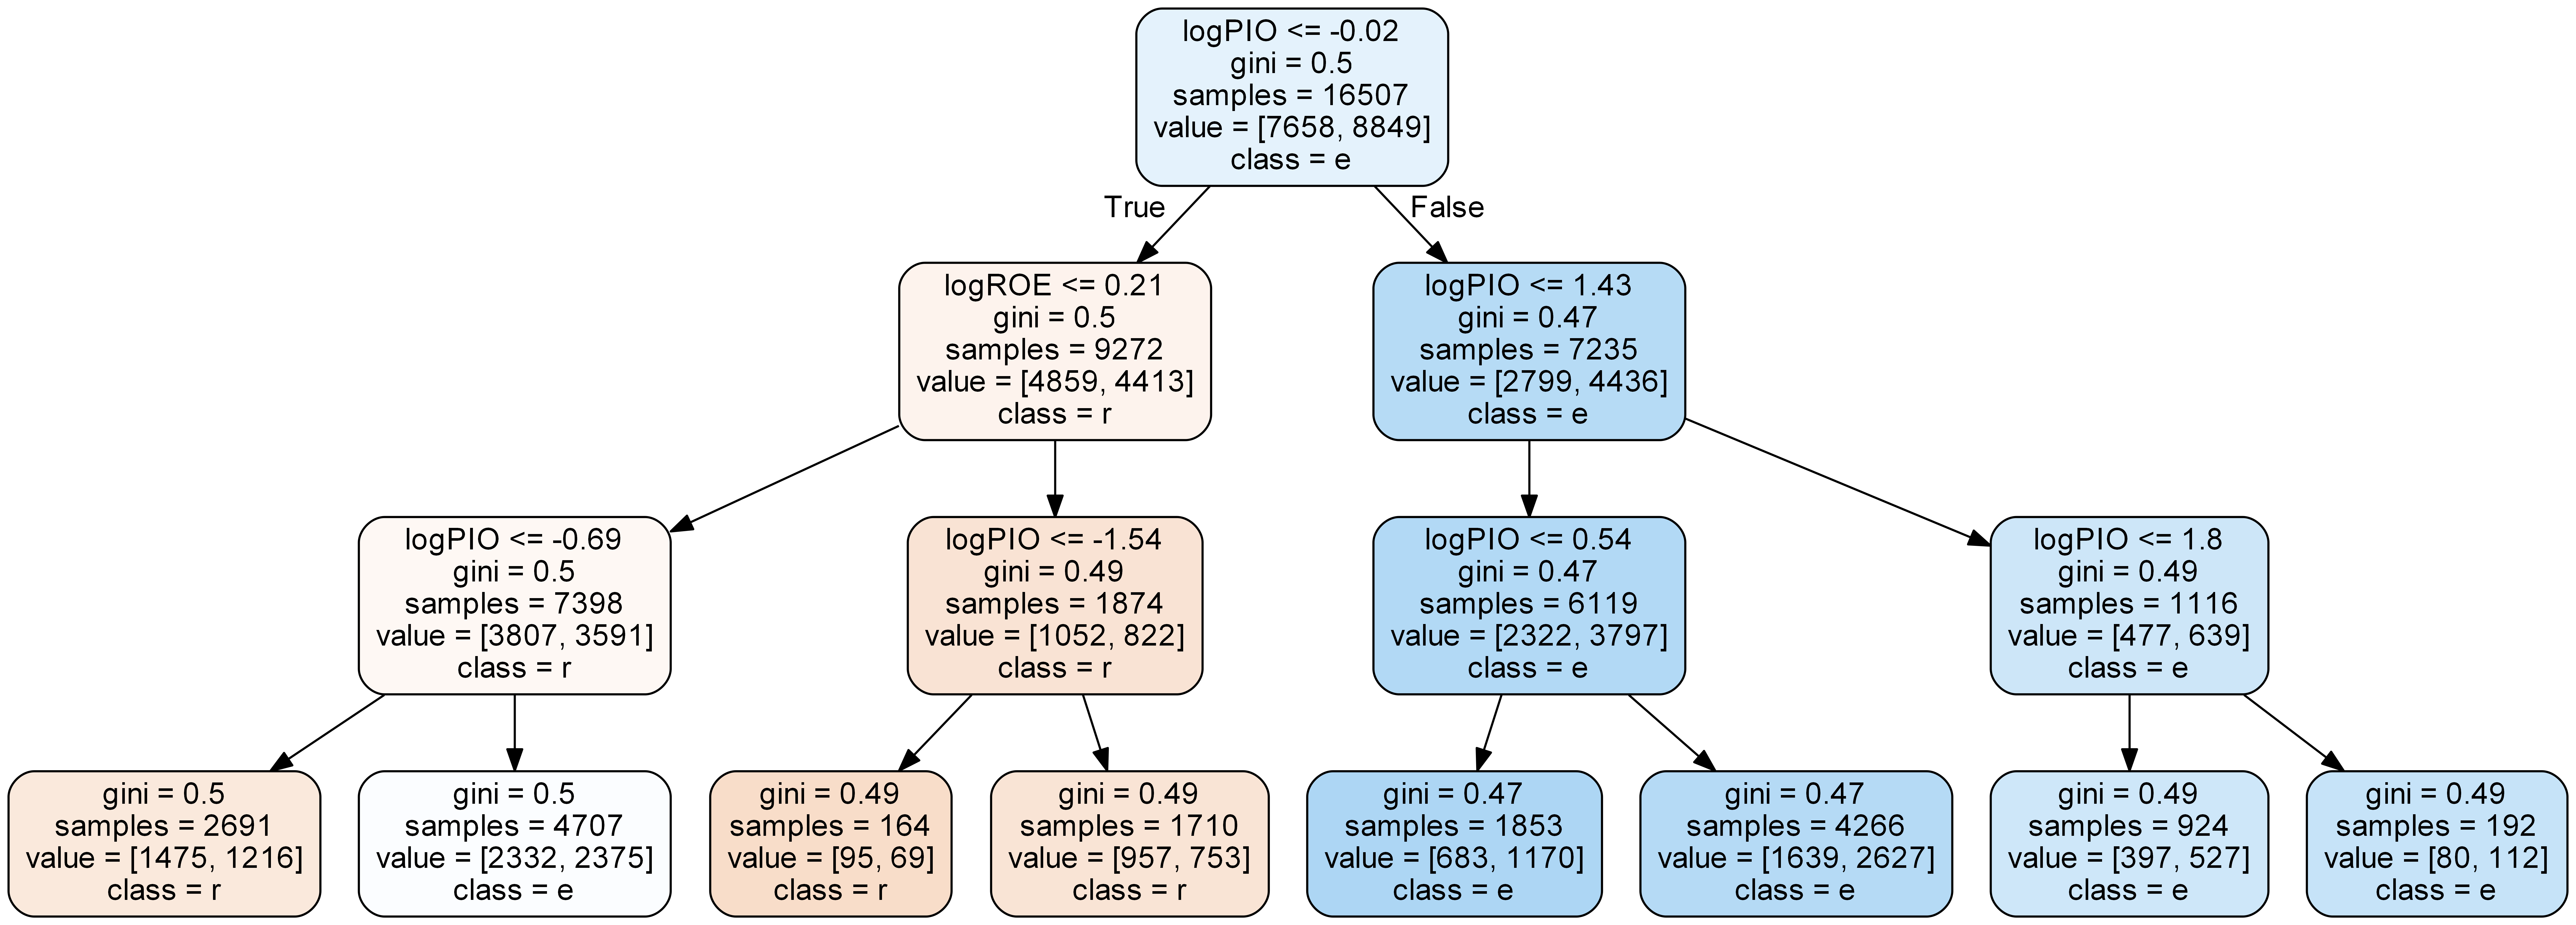

In [26]:
from IPython.display import Image
Image(filename = 'tree.png')

In [27]:
def compare_nan_array(func, a, thresh):
    out = ~np.isnan(a)
    out[out] = func(a[out] , thresh)
    return out

longs = pd.DataFrame(compare_nan_array(np.greater, retPred, .5).astype(int)).shift(1) #1 day later
shorts = pd.DataFrame(compare_nan_array(np.less, retPred, .5).astype(int)).shift(1)

longs.iloc[0] = 0
shorts.iloc[0] = 0

# positions: buy=1 or not=0
positions = np.zeros(retPred.shape)

for h in range(holdingDays):
    long_lag = longs.shift(h)
    long_lag.fillna(value=0, inplace=True)
    long_lag = long_lag.to_numpy(dtype=bool)
    
    short_lag = shorts.shift(h)
    short_lag.fillna(value=0, inplace=True)
    short_lag = short_lag.to_numpy(dtype=bool)
    
    positions[long_lag] += 1
    positions[short_lag] -= 1

In [28]:
dRetA = np.sum(np.multiply(pd.DataFrame(positions).shift(1).fillna(0).to_numpy().squeeze(), Ret1train.fillna(0).to_numpy()), axis=1)
dPos = np.sum(pd.DataFrame(positions).shift(1).abs().to_numpy().squeeze(), axis=1)

In [29]:
dailyRet = np.divide(dRetA, dPos, out=np.zeros_like(dRetA), where=dPos!=0)
dailyRet[~np.isfinite(dailyRet)] = 0
cumret = np.cumprod(1 + dailyRet) - 1 #cummulative returns=equity curve


C:\Users\melan\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In-sample: CAGR=0.183023 Sharpe ratio=1.77223 maxDD=-0.066276 maxDDD=68 Calmar ratio=2.76154
shorts?:  1.0


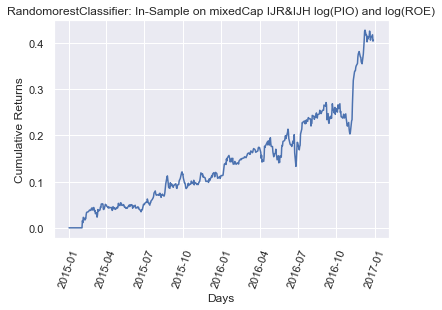

In [30]:
plt.figure(1)
plt.xticks(rotation=70) 
plt.plot(datesTrain, cumret)
#plt.plot(range(trainSize), cumret)
plt.title('RandomorestClassifier: In-Sample on mixedCap IJR&IJH log(PIO) and log(ROE)')
plt.ylabel('Cumulative Returns')
plt.xlabel('Days')

cagr = (1 + cumret[-1]) ** (252 / trainSize) - 1
maxDD, maxDDD, _ = fn.calculateMaxDD(cumret)
ratio = (252.0 ** 0.5) * np.mean(dailyRet) / np.std(dailyRet)
#financial metrics
print(('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

print("shorts?: ", shorts.max().max())


In [32]:
# Make real predictions on test (out-of-sample)
#Ypred = linregModel.predict(Xtest)
Ypred = treeModel.predict(Xtest)
#Ypred = treeModel.predict(Xest).reshape(-1,1)

print(('accuracy_score-testing = {:.4f}').format(accuracy_score(ytest, Ypred)))

retPred = np.nan * np.empty((RetFutTest.size, 1))
Ypred = np.reshape(Ypred,(Ypred.shape[0],1))
retPred[ixCleanTest] = Ypred
retPred = retPred.reshape(RetFutTest.shape)

longs = pd.DataFrame(compare_nan_array(np.greater, retPred, .5).astype(int)).shift(1) #1 day later: probabilities
shorts = pd.DataFrame(compare_nan_array(np.less, retPred, .5).astype(int)).shift(1) #1 day later: probabilities

longs.iloc[0] = 0
shorts.iloc[0] = 0

positions = np.zeros(retPred.shape)

for h in range(holdingDays):
    long_lag = longs.shift(h)
    long_lag.fillna(value=0, inplace=True)
    long_lag = long_lag.to_numpy(dtype=bool)
    
    short_lag = shorts.shift(h)
    short_lag.fillna(value=0, inplace=True)
    short_lag = short_lag.to_numpy(dtype=bool)
    
    positions[long_lag] += 1
    positions[short_lag] -= 1

dRetA = np.sum(np.multiply(pd.DataFrame(positions).shift(1).fillna(0).to_numpy().squeeze(), Ret1test.fillna(0).to_numpy()), axis=1)
dPos = np.sum(pd.DataFrame(positions).shift(1).abs().to_numpy().squeeze(), axis=1)

dailyRet = np.divide(dRetA, dPos, out=np.zeros_like(dRetA), where=dPos!=0)
dailyRet[~np.isfinite(dailyRet)] = 0
cumret = np.cumprod(1 + dailyRet) - 1


accuracy_score-testing = 0.4818


Out-of-sample: CAGR=-0.0151936 Sharpe ratio=-0.048852 maxDD=-0.262293 maxDDD=106 Calmar ratio=-0.0579261


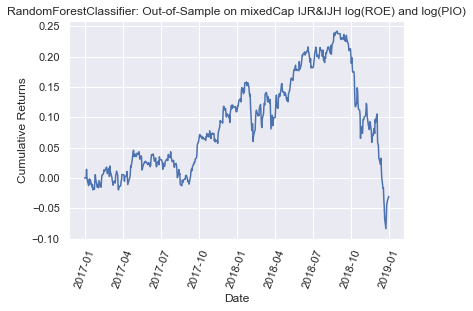

shorts?:  1.0


In [33]:
register_matplotlib_converters()

plt.figure(2)
plt.xticks(rotation=70) 
plt.plot(datesTest, cumret)
plt.title('RandomForestClassifier: Out-of-Sample on mixedCap IJR&IJH log(ROE) and log(PIO)')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')

cagr = (1 + cumret[-1]) ** (252 / testSize) - 1
maxDD, maxDDD, _ = fn.calculateMaxDD(cumret)
ratio = (252.0 ** 0.5) * np.mean(dailyRet) / np.std(dailyRet)
print(('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

plt.show() 
print("shorts?: ",shorts.max().max())
